In [2]:
from pyspark.sql import SparkSession

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import nltk
from nltk.corpus import stopwords
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier 


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [6]:
# define English stopwords
stop_words = stopwords.words('english')

In [8]:
spark = SparkSession.builder.appName("Tweets Sentiment with in PySpark").getOrCreate()

In [10]:
train_set = spark.read.csv('twitter_training.csv', header = False, inferSchema = True)
val_set = spark.read.csv('twitter_validation.csv', header = False, inferSchema = True)


root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)



In [11]:
train_set.printSchema()
train_set.show(5, False)

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)

+----+-----------+--------+---------------------------------------------------------+
|_c0 |_c1        |_c2     |_c3                                                      |
+----+-----------+--------+---------------------------------------------------------+
|2401|Borderlands|Positive|im getting on borderlands and i will murder you all ,    |
|2401|Borderlands|Positive|I am coming to the borders and I will kill you all,      |
|2401|Borderlands|Positive|im getting on borderlands and i will kill you all,       |
|2401|Borderlands|Positive|im coming on borderlands and i will murder you all,      |
|2401|Borderlands|Positive|im getting on borderlands 2 and i will murder you me all,|
+----+-----------+--------+---------------------------------------------------------+
only showing top 5 rows



In [13]:
columns = ['id', 'company', 'label', 'text']

# rename columns
for i, col_name in enumerate(columns):
    train_set = train_set.withColumnRenamed('_c{}'.format(i), col_name)
    val_set = val_set.withColumnRenamed('_c{}'.format(i), col_name)

In [15]:
train_set.printSchema()
train_set.show(5, False)
train_set.count()

root
 |-- id: integer (nullable = true)
 |-- company: string (nullable = true)
 |-- label: string (nullable = true)
 |-- text: string (nullable = true)

+----+-----------+--------+---------------------------------------------------------+
|id  |company    |label   |text                                                     |
+----+-----------+--------+---------------------------------------------------------+
|2401|Borderlands|Positive|im getting on borderlands and i will murder you all ,    |
|2401|Borderlands|Positive|I am coming to the borders and I will kill you all,      |
|2401|Borderlands|Positive|im getting on borderlands and i will kill you all,       |
|2401|Borderlands|Positive|im coming on borderlands and i will murder you all,      |
|2401|Borderlands|Positive|im getting on borderlands 2 and i will murder you me all,|
+----+-----------+--------+---------------------------------------------------------+
only showing top 5 rows



74682

In [18]:
# drop missing value of text column
train_set = train_set.dropna(subset=['text'])
val_set = val_set.dropna(subset=['text'])
train_set.count()

73996

In [19]:
from pyspark.ml.feature import StringIndexer, StopWordsRemover, CountVectorizer, Tokenizer

In [34]:
train_set=train_set.drop('int_label')
val_set=val_set.drop('int_label')

In [35]:
# mapping label with index
label_indexer = StringIndexer(inputCol='label', outputCol='int_label')

label_indexer_model = label_indexer.fit(train_set)
train_set = label_indexer_model.transform(train_set)
val_set = label_indexer_model.transform(val_set)

# extract label mapping
label_mapping = label_indexer_model.labels

for i, val in enumerate(label_mapping):
    print(f'index {i} --> label {val}')

train_set.show(5, False)

index 0 --> label Negative
index 1 --> label Positive
index 2 --> label Neutral
index 3 --> label Irrelevant
+----+-----------+--------+---------------------------------------------------------+---------+
|id  |company    |label   |text                                                     |int_label|
+----+-----------+--------+---------------------------------------------------------+---------+
|2401|Borderlands|Positive|im getting on borderlands and i will murder you all ,    |1.0      |
|2401|Borderlands|Positive|I am coming to the borders and I will kill you all,      |1.0      |
|2401|Borderlands|Positive|im getting on borderlands and i will kill you all,       |1.0      |
|2401|Borderlands|Positive|im coming on borderlands and i will murder you all,      |1.0      |
|2401|Borderlands|Positive|im getting on borderlands 2 and i will murder you me all,|1.0      |
+----+-----------+--------+---------------------------------------------------------+---------+
only showing top 5 rows



In [37]:
from pyspark.sql.functions import regexp_replace, lower

In [38]:
# cleaning text
def clean_text(df, inputCol='text', outputCol='text'):
    # remove link https, http, ...
    df = df.withColumn(outputCol, regexp_replace(df[inputCol], r'https?://\S+|www\.\S+|S+\.com\S+|youtu.\be/\S+', ''))
    # remove starting with @ or #
    df = df.withColumn(outputCol, regexp_replace(df[inputCol], r'(@|#)\w+', ''))
    # convert text to lowercase
    df = df.withColumn(outputCol, lower(df[inputCol]))
    # remove non-alpha characters
    df = df.withColumn(outputCol, regexp_replace(df[inputCol], r'[^a-zA-Z\s]', ''))
    
    return df

In [40]:
cleaned_train_set = clean_text(train_set, inputCol='text', outputCol='text')
cleaned_val_set = clean_text(val_set, inputCol='text', outputCol='text')
cleaned_train_set.show(5, False)

+----+-----------+--------+-------------------------------------------------------+---------+
|id  |company    |label   |text                                                   |int_label|
+----+-----------+--------+-------------------------------------------------------+---------+
|2401|Borderlands|Positive|im getting on borderlands and i will murder you all    |1.0      |
|2401|Borderlands|Positive|i am coming to the borders and i will kill you all     |1.0      |
|2401|Borderlands|Positive|im getting on borderlands and i will kill you all      |1.0      |
|2401|Borderlands|Positive|im coming on borderlands and i will murder you all     |1.0      |
|2401|Borderlands|Positive|im getting on borderlands  and i will murder you me all|1.0      |
+----+-----------+--------+-------------------------------------------------------+---------+
only showing top 5 rows



In [43]:
# define tokenizer
tokenizer = Tokenizer(inputCol='text', outputCol='token')

# define stopwords remover
stopword_remover = StopWordsRemover(inputCol='token', outputCol='filtered_token', stopWords=stop_words)

# define countVectorizer
count_vectorizer = CountVectorizer(inputCol='filtered_token', outputCol='features', vocabSize=10000, minDF=5)

# define Logistic Regression and RandomForest model
lr = LogisticRegression(labelCol='int_label', featuresCol='features', maxIter= 100)
rf = RandomForestClassifier(labelCol='int_label', featuresCol='features', numTrees=100, maxDepth=10)


In [41]:
from pyspark.ml import Pipeline

In [44]:
# create pipelines
lr_pipeline = Pipeline(stages=[tokenizer, stopword_remover, count_vectorizer, lr])
rf_pipeline = Pipeline(stages=[tokenizer, stopword_remover, count_vectorizer, rf])

# fit the models
lr_model = lr_pipeline.fit(cleaned_train_set)
rf_model = rf_pipeline.fit(cleaned_train_set)

# transform the data
lr_predictions = lr_model.transform(cleaned_train_set)
rf_predictions = rf_model.transform(cleaned_train_set)

In [45]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="int_label", predictionCol="prediction", metricName="accuracy")

lr_accuracy = evaluator.evaluate(lr_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

print(f"Logistic Regression Accuracy on Training Set: {lr_accuracy}")
print(f"RandomForest Accuracy on Training Set: {rf_accuracy}")


Logistic Regression Accuracy on Training Set: 0.900089194010487
RandomForest Accuracy on Training Set: 0.45413265581923346


Accuracy: 0.872


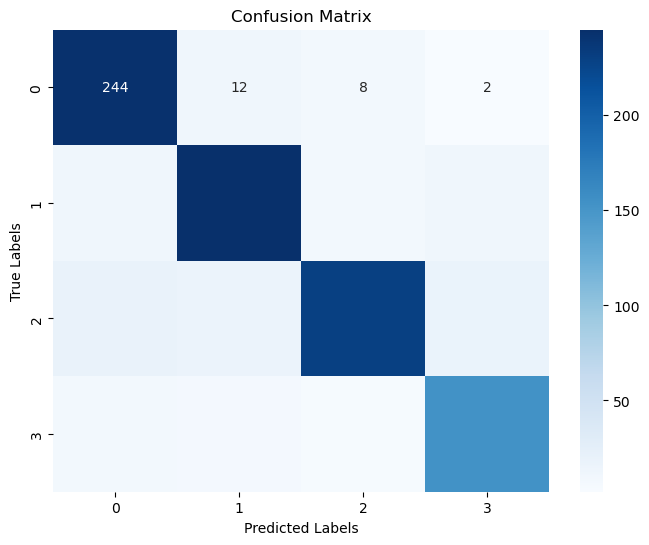

In [51]:
# because accuracy of logistic regression greater than randomforest, I will use it to evaluate validation set
# apply model to validation set
processed_val_set = lr_model.transform(cleaned_val_set)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="int_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(processed_val_set)
print("Accuracy:", accuracy)

# --- Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Convert Spark DataFrame to Pandas DataFrame
prediction_and_label_pd = processed_val_set.select("prediction", "int_label").toPandas()

# Extract predicted labels and true labels
predicted_labels = prediction_and_label_pd["prediction"].tolist()
true_labels = prediction_and_label_pd["int_label"].tolist()

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [52]:
lr_model.write().overwrite().save('logistic_regression_model.pkl')

In [53]:
# stop SparkSession
spark.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x00000249ECF102D0>>